In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import zscore
import seaborn as sns
from sklearn import metrics

#Q1: Import and store the data in a data frame.
cancerdata = pd.read_csv("D:/D_DATA/CODE/Python/R2 KNN Wisconsin cancer diagnosis/breast-cancer-wisconsin.data",
                        names=['Id', 'ClumpThickness','CellSizeUniformity','CellShapeUniformity','MarginalAdhesion','SingleEpithelialCellSize','BareNuclei','BlandChromatin','NormalNucleoli','Mitoses','Class'], header=None)

print(cancerdata.shape)
print(cancerdata.dtypes)
cancerdata.sample(n=3)

(699, 11)
Id                           int64
ClumpThickness               int64
CellSizeUniformity           int64
CellShapeUniformity          int64
MarginalAdhesion             int64
SingleEpithelialCellSize     int64
BareNuclei                  object
BlandChromatin               int64
NormalNucleoli               int64
Mitoses                      int64
Class                        int64
dtype: object


,Id,ClumpThickness,CellSizeUniformity,CellShapeUniformity,MarginalAdhesion,SingleEpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
519,1330439,4,7,8,3,4,10,9,1,1,4
606,353098,4,1,1,2,2,1,1,1,1,2
401,1213784,3,1,1,1,2,1,1,1,1,2


In [163]:
print(cancerdata.describe().transpose())
#Observation: Right tailed distribution as Mean is higher for each of the features. 

print(cancerdata.groupby(["Class"]).count())
#Class distribution among B and M is roughly close to 2:1. The model will better predict Class 2 Benign than class 4 due to bias
#towards higher representative class. 

#convert to numeric - replace `?` to NaN and cast to float
#cancerdata['BareNuclei'] = cancerdata['BareNuclei'].replace('?', np.nan).astype(int64)
#Below version is more general than above as it will coerce any non-numeric
cancerdata['BareNuclei'] = pd.to_numeric(cancerdata['BareNuclei'], errors='coerce')
#replace NaNs by means
cancerdata['BareNuclei'] = cancerdata['BareNuclei'].fillna(cancerdata['BareNuclei'].mean())
#Check if there are any nulls
print(cancerdata.isnull().sum().sum())


                          count          mean            std      min  \
Id                        699.0  1.071704e+06  617095.729819  61634.0   
ClumpThickness            699.0  4.417740e+00       2.815741      1.0   
CellSizeUniformity        699.0  3.134478e+00       3.051459      1.0   
CellShapeUniformity       699.0  3.207439e+00       2.971913      1.0   
MarginalAdhesion          699.0  2.806867e+00       2.855379      1.0   
SingleEpithelialCellSize  699.0  3.216023e+00       2.214300      1.0   
BlandChromatin            699.0  3.437768e+00       2.438364      1.0   
NormalNucleoli            699.0  2.866953e+00       3.053634      1.0   
Mitoses                   699.0  1.589413e+00       1.715078      1.0   
Class                     699.0  2.689557e+00       0.951273      2.0   

                               25%        50%        75%         max  
Id                        870688.5  1171710.0  1238298.0  13454352.0  
ClumpThickness                 2.0        4.0        6

In [164]:
print(cancerdata.dtypes)
print(cancerdata["BareNuclei"].value_counts())
print(cancerdata.median())
print(cancerdata.describe().transpose())


Id                            int64
ClumpThickness                int64
CellSizeUniformity            int64
CellShapeUniformity           int64
MarginalAdhesion              int64
SingleEpithelialCellSize      int64
BareNuclei                  float64
BlandChromatin                int64
NormalNucleoli                int64
Mitoses                       int64
Class                         int64
dtype: object
1.000000     402
10.000000    132
5.000000      30
2.000000      30
3.000000      28
8.000000      21
4.000000      19
3.544656      16
9.000000       9
7.000000       8
6.000000       4
Name: BareNuclei, dtype: int64
Id                          1171710.0
ClumpThickness                    4.0
CellSizeUniformity                1.0
CellShapeUniformity               1.0
MarginalAdhesion                  1.0
SingleEpithelialCellSize          2.0
BareNuclei                        1.0
BlandChromatin                    3.0
NormalNucleoli                    1.0
Mitoses                       

In [165]:
feature_column_names=cancerdata.columns.drop("Id").drop("Class")
print(feature_column_names)
print(cancerdata.columns)
cancerdata_z=cancerdata
cancerdata_z[feature_column_names]=cancerdata[feature_column_names].apply(zscore)
print(cancerdata_z.columns)
print(cancerdata_z.head(4))


Index(['ClumpThickness', 'CellSizeUniformity', 'CellShapeUniformity',
       'MarginalAdhesion', 'SingleEpithelialCellSize', 'BareNuclei',
       'BlandChromatin', 'NormalNucleoli', 'Mitoses'],
      dtype='object')
Index(['Id', 'ClumpThickness', 'CellSizeUniformity', 'CellShapeUniformity',
       'MarginalAdhesion', 'SingleEpithelialCellSize', 'BareNuclei',
       'BlandChromatin', 'NormalNucleoli', 'Mitoses', 'Class'],
      dtype='object')
Index(['Id', 'ClumpThickness', 'CellSizeUniformity', 'CellShapeUniformity',
       'MarginalAdhesion', 'SingleEpithelialCellSize', 'BareNuclei',
       'BlandChromatin', 'NormalNucleoli', 'Mitoses', 'Class'],
      dtype='object')
        Id  ClumpThickness  CellSizeUniformity  CellShapeUniformity  \
0  1000025        0.206936           -0.699995            -0.743299   
1  1002945        0.206936            0.283845             0.266875   
2  1015425       -0.503866           -0.699995            -0.743299   
3  1016277        0.562336            

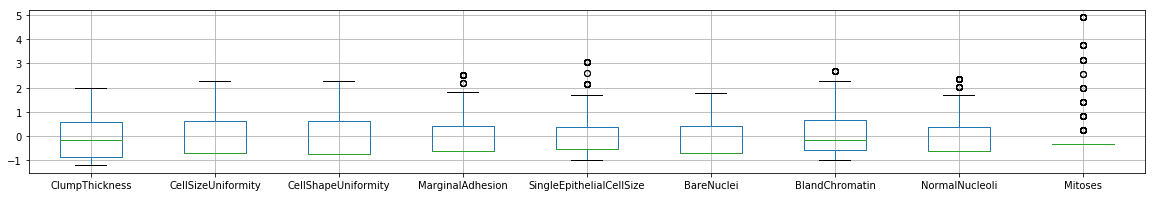

In [166]:
%matplotlib inline


cancerdata_z[feature_column_names].boxplot(figsize=(20,3))

In [167]:
def drop_outliers(df):
    print(df.shape)
    for i in df.describe().columns:
        if i == "Id" or i == "Class":
            continue
        lower, upper = -3, 3        
        df.drop(df[df[i] > upper].index, inplace=True)
        df.drop(df[df[i] < lower].index, inplace=True)
        
                    
    print(df.shape)
    return df

print(cancerdata_z.shape)
#Q2: Remove the outliers from the data
cancerdata_z_no_outliers=drop_outliers(cancerdata_z)
print(cancerdata_z_no_outliers.shape)


(699, 11)
(699, 11)
(648, 11)
(648, 11)


In [168]:
#Q3: Treat “diagnosis” – 2nd Column as your Dependent Variable and Rest of the columns as Independent Variable and split the table. 
cancerdata_z_no_outliers_class = pd.to_numeric(cancerdata_z_no_outliers["Class"], errors='coerce')
#Q4: Drop "id" column from independent variables (Extract only the independent attributes by removing Id, Class)
cancerdata_z_no_outliers_features=cancerdata_z_no_outliers.drop(labels=["Id","Class"], axis=1)

In [169]:
print(cancerdata_z_no_outliers_class.head(3))
print(cancerdata_z_no_outliers_class.dtypes)
print(cancerdata_z_no_outliers_class.value_counts())
print(cancerdata_z_no_outliers_features.head(3))
print(cancerdata_z_no_outliers.shape,cancerdata_z_no_outliers_class.shape,cancerdata_z_no_outliers_features.shape)

0    2
1    2
2    2
Name: Class, dtype: int64
int64
2    455
4    193
Name: Class, dtype: int64
   ClumpThickness  CellSizeUniformity  CellShapeUniformity  MarginalAdhesion  \
0        0.206936           -0.699995            -0.743299         -0.633247   
1        0.206936            0.283845             0.266875          0.768621   
2       -0.503866           -0.699995            -0.743299         -0.633247   

   SingleEpithelialCellSize  BareNuclei  BlandChromatin  NormalNucleoli  \
0                 -0.549561   -0.706991       -0.179662       -0.611825   
1                  1.710106    1.793513       -0.179662       -0.284112   
2                 -0.549561   -0.429158       -0.179662       -0.611825   

    Mitoses  
0 -0.343912  
1 -0.343912  
2 -0.343912  
(648, 11) (648,) (648, 9)


In [170]:
#Q6: Drop the independent variables which has less than 0.1 correlation with the dependent variable
print(cancerdata_z_no_outliers_features.var())
#Answer - no need to drop any column as variance is over 0.1 for each of the columns. 

ClumpThickness              0.914012
CellSizeUniformity          0.826390
CellShapeUniformity         0.824455
MarginalAdhesion            0.841936
SingleEpithelialCellSize    0.539381
BareNuclei                  0.922579
BlandChromatin              0.871865
NormalNucleoli              0.878053
Mitoses                     0.195745
dtype: float64


['ClumpThickness', 'CellSizeUniformity', 'CellShapeUniformity', 'MarginalAdhesion', 'SingleEpithelialCellSize', 'BareNuclei', 'BlandChromatin', 'NormalNucleoli', 'Mitoses']


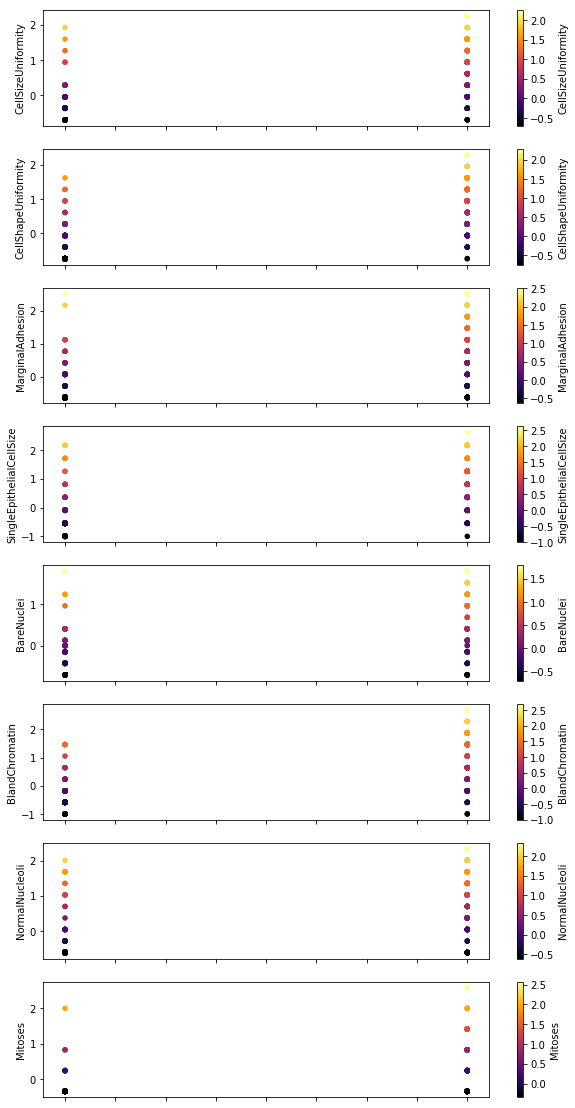

In [152]:
#Q7: Create scatter Plot of Independent Variable vs Dependent Variable. (2 points)


colnames = list (cancerdata_z_no_outliers_features.columns)
print(colnames)
fig, axes = plt.subplots(nrows=len(colnames)-1, sharex = True,figsize = (10,20),)

for i, ax in enumerate(axes):
    cancerdata_z_no_outliers.reset_index().plot(x="Class", y=colnames[i+1], kind = 'scatter', legend=False, 
                          ax=ax, c=colnames[i+1], cmap="inferno")

plt.show()

In [171]:
#Q8: Divide the data set into training and test data set and build a KNN model.
X = np.array(cancerdata_z_no_outliers_features)
print(X.shape)
y = np.array(cancerdata_z_no_outliers_class)
print(y.shape)

# Split X and y into training and test set in 75:25 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

#print(X_train.shape,X_test.shape,y_train,y_test)
# Call Nearest Neighbour algorithm
NNH = KNeighborsClassifier(n_neighbors= 5 , weights = 'distance' )
NNH.fit(X_train, y_train)
# For every test data point, predict it's label based on 5 nearest neighbours in this model. The majority class will 
# be assigned to the test data point

NNH.score(X_test, y_test)
#predicted_labels = NNH.predict(X_test)
y_predict = NNH.predict(X_test)



# empty list that will hold cv scores
cv_scores = []
k_neighbors = []
accuracy_scores = []

# perform 10-fold cross validation
for k in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    k_neighbors.append(k)
    
    
#Answer
print(pd.DataFrame(k_neighbors,cv_scores))

myList = list(range(1,50))
MSE = [1 - x for x in cv_scores]
min_MSE=min(MSE)
#print(MSE.index(min(MSE)))
best_accuracyscore=cv_scores[MSE.index(min(MSE))]
best_k = myList[MSE.index(min(MSE))]
#Q9: Print the optimal value of K using Mis-classification error and the corresponding accuracy for the model 
print ("The optimal number of neighbors is %d with accuracy score: %f and Mis-classification error: %f" % (best_k,best_accuracyscore,min_MSE))

(648, 9)
(648,)
           0
0.971304   1
0.971353   2
0.969082   3
0.971256   4
0.971208   5
0.971208   6
0.971208   7
0.969034   8
0.966812   9
0.964638  10
0.966812  11
0.964638  12
0.966812  13
0.964638  14
0.964638  15
0.966860  16
0.971256  17
0.966812  18
0.966812  19
0.966812  20
0.966812  21
0.966812  22
0.966812  23
0.964638  24
0.966812  25
0.964638  26
0.964638  27
0.964638  28
0.964638  29
0.964638  30
0.964638  31
0.962415  32
0.962415  33
0.962415  34
0.962415  35
0.962415  36
0.962415  37
0.962415  38
0.962415  39
0.962415  40
0.962415  41
0.962415  42
0.962415  43
0.960242  44
0.962415  45
0.960242  46
0.962415  47
0.960242  48
0.960242  49
The optimal number of neighbors is 2 with accuracy score: 0.971353 and Mis-classification error: 0.028647


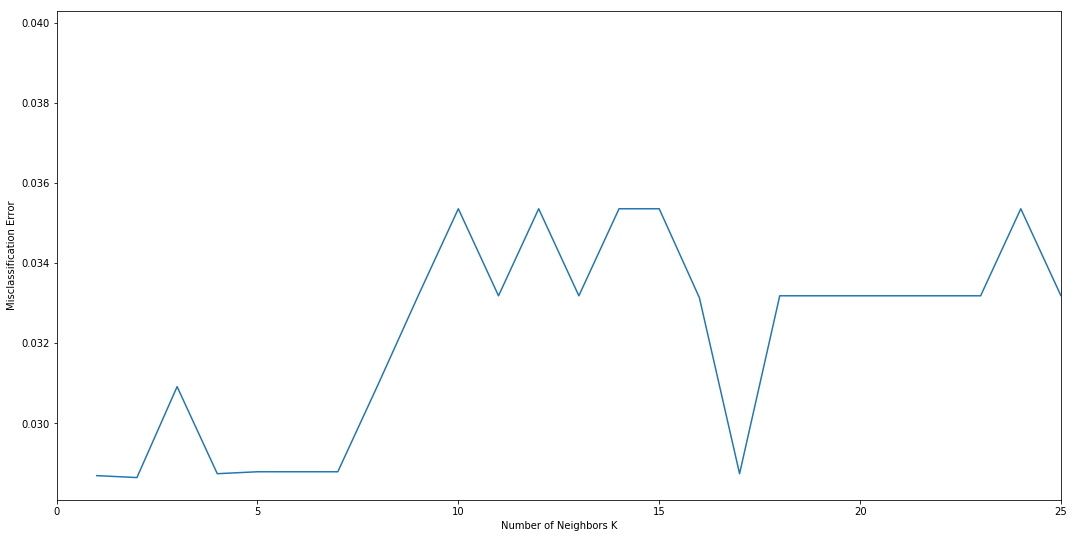

In [172]:
#Q10: Plot misclassification error vs k (with k value on X-axis) using matplotlib.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

plt.xlim(0,25)


# plot misclassification error vs k
plt.plot(k_neighbors, MSE)



plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()